<a href="https://colab.research.google.com/github/Samannita29/bloodcell/blob/main/BLOODCELL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
train_dir = '/content/gdrive/MyDrive/csv/dataset2-master/images/TRAIN'
test_dir = '/content/gdrive/MyDrive/csv/dataset2-master/images/TEST'

In [ ]:
# Create generators

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Flow image data

train_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2061 images belonging to 4 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
249/249 [==============================] - 2494s 10s/step - loss: 0.8368 - accuracy: 0.6514 - val_loss: 0.5649 - val_accuracy: 0.7868
Epoch 2/100
249/249 [==============================] - 33s 131ms/step - loss: 0.4828 - accuracy: 0.8173 - val_loss: 0.4177 - val_accuracy: 0.8416
Epoch 3/100
249/249 [==============================] - 33s 131ms/step - loss: 0.3835 - accuracy: 0.8544 - val_loss: 0.3945 - val_accuracy: 0.8436
Epoch 4/100
249/249 [==============================] - 32s 130ms/step - loss: 0.2801 - accuracy: 0.8945 - val_loss: 0.3849 - val_accuracy: 0.8371
Epoch 5/100
249/249 [==============================] - 33s 131ms/step - loss: 0.2195 - accuracy: 0.9197 - val_loss: 0.3071 - val_accuracy: 0.8743
Epoch 6/100
249/249 [==============================] - 33s 131ms/step - loss: 0.1842 - accuracy: 0.9367 - val_loss: 0.2481 - val_accuracy: 0.9045
Epoch 7/100
249/249 [==============================] - 32s 129ms/step - loss: 0.1612 - accuracy: 0.9425 - val_loss: 0.2686 -

In [ ]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

In [ ]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

Test Accuracy: 52.790%


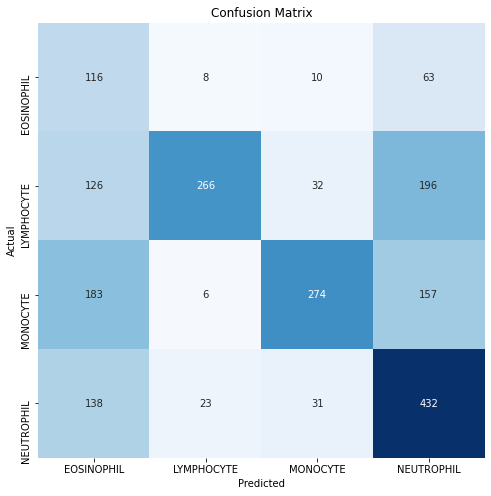

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.21      0.59      0.31       197
  LYMPHOCYTE       0.88      0.43      0.58       620
    MONOCYTE       0.79      0.44      0.57       620
  NEUTROPHIL       0.51      0.69      0.59       624

    accuracy                           0.53      2061
   macro avg       0.60      0.54      0.51      2061
weighted avg       0.68      0.53      0.55      2061



In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

Found 1989 images belonging to 4 classes.
Validation Accuracy: 93.565%


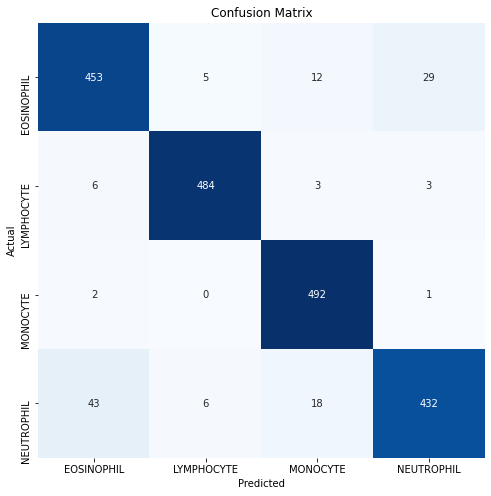

Classification Report:
----------------------
               precision    recall  f1-score   support

  EOSINOPHIL       0.90      0.91      0.90       499
  LYMPHOCYTE       0.98      0.98      0.98       496
    MONOCYTE       0.94      0.99      0.96       495
  NEUTROPHIL       0.93      0.87      0.90       499

    accuracy                           0.94      1989
   macro avg       0.94      0.94      0.94      1989
weighted avg       0.94      0.94      0.94      1989



In [ ]:
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='validation'
)


predictions = np.argmax(model.predict(val_images), axis=1)

acc = accuracy_score(val_images.labels, predictions)
cm = tf.math.confusion_matrix(val_images.labels, predictions)
clr = classification_report(val_images.labels, predictions, target_names=CLASS_NAMES)

print("Validation Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)